In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Masking
from keras.layers import BatchNormalization
from keras import optimizers
from keras.utils import Sequence
from keras.callbacks import BaseLogger
from keras.models import load_model
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt

import pickle
import pandas as pd
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
import datetime
from scipy import spatial


Using TensorFlow backend.


In [9]:
VECSIZE = 100

In [5]:
class ShowLoss(tf.keras.callbacks.Callback):
 
    def __init__(self):
        super(ShowLoss, self).__init__()
        self.loss = []

    def on_train_end(self, batch, logs=None):
        fig = plt.figure()
        plt.plot(np.arange(0,len(self.loss)), self.loss, '+', linestyle="-")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.axis(ymin=0)
        plt.show()
        fig.savefig(f'./loss_{datetime.datetime.now().strftime("%d%m%y_%H:%M:%S")}.png')
    def on_epoch_end(self, epoch, logs=None):
        self.loss.append(logs['loss'])


In [6]:
vectors = pickle.load(open("vectors_doc2vec_sessions.pickle", 'rb'))
#np.random.shuffle(vectors)
_sep = int(len(vectors)*0.7)
_train, _test = vectors[:_sep], vectors[_sep:]
print(len(_train), len(_test))

706 303


In [7]:
def gen_sequences(dataset, vector_size, height = 5):
    while True:
        for _batch in dataset:
            for _h in range(1, len(_batch), height):
                _size = min(height, len(_batch)-_h)
                _x = np.zeros((_size, len(_batch)-1, vector_size))
                _y = np.empty((_size, vector_size))
                for _i in range(0, _size):
                    for _j in range(0, _i+_h):
                        _x[_i][_j] = _batch[_j]
                    _y[_i] = _batch[_i+_h]
                yield _x, _y

for i, seq in enumerate(itertools.islice(gen_sequences([[1,2,3,4], [1,2,3,4,5,6]], 1, height=1), 0, 10)):
    print(i)
    for j, x in enumerate(seq[0]):
        print(x, "  : ", seq[1][j])

0
[[1.]
 [0.]
 [0.]]   :  [2.]
1
[[1.]
 [2.]
 [0.]]   :  [3.]
2
[[1.]
 [2.]
 [3.]]   :  [4.]
3
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]]   :  [2.]
4
[[1.]
 [2.]
 [0.]
 [0.]
 [0.]]   :  [3.]
5
[[1.]
 [2.]
 [3.]
 [0.]
 [0.]]   :  [4.]
6
[[1.]
 [2.]
 [3.]
 [4.]
 [0.]]   :  [5.]
7
[[1.]
 [2.]
 [3.]
 [4.]
 [5.]]   :  [6.]
8
[[1.]
 [0.]
 [0.]]   :  [2.]
9
[[1.]
 [2.]
 [0.]]   :  [3.]


In [8]:
_args = {"epochs":75, "steps_per_epoch":2000}
_largs = {"activation":"tanh", "dropout":0}
nn = Sequential()
nn.add(Masking(mask_value=0., input_shape=(None,VECSIZE)))
nn.add(LSTM(50, return_sequences=True, **_largs))
nn.add(LSTM(50, return_sequences=True, **_largs))
nn.add(LSTM(50, return_sequences=True, **_largs))
nn.add(LSTM(50, return_sequences=True, **_largs))
nn.add(LSTM(50, **_largs))
nn.add(BatchNormalization())
nn.add(Dense(VECSIZE))
nn.compile(loss='cosine_proximity', optimizer="adam")
nn.summary()

nn.fit_generator(generator=gen_sequences(_train, VECSIZE, height=100), **_args, verbose=1, callbacks=[ShowLoss()])

NameError: name 'VECSIZE' is not defined

In [70]:
nn.evaluate_generator(generator=gen_sequences(_test, VECSIZE, height=100), steps=200)

-0.6320020100671097

In [ ]:
nn.save("./lstm5x50_sess_cosine_BN")

In [10]:
nn = load_model("./lstm5x50_sess")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [11]:
def dist(sampleA, sampleB):
    _e = 0
    for _f in range(len(sampleA)):
        _e =+ pow(sampleA[_f]-sampleB[_f], 2)
    return _e

In [12]:
def sampleDistances(sample):
    #rank : {dist : (batch, sample)}
    _dists = {}
    for _b in range(len(vectors)):
        for _s in range(1, len(vectors[_b])):
            _dist = spatial.distance.cosine(sample, vectors[_b][_s])
            _dists[_dist] = (_b, _s)
    _rank, _r = {}, 0
    for _k in sorted(_dists):
        _r +=1
        _rank[_r] = (_k ,_dists[_k])
    return _rank

def searchRank(_rank, _b, _s):
    for _r in _rank:
        if _rank[_r][1][0] == _b and _rank[_r][1][1] == _s:
            return (_r, _rank[_r][0])
    return None

In [12]:
c, s = 30, 1
rank = sampleDistances(nn.predict(np.array([vectors[c][:s]]))[0])
searchRank(rank, c, s)

(904, 0.2686132788658142)

In [74]:
rank

{1: (0.07792973518371582, (40, 3)),
 2: (0.08135467767715454, (25, 4)),
 3: (0.0814623236656189, (28, 7)),
 4: (0.08435231447219849, (29, 1)),
 5: (0.08572030067443848, (31, 5)),
 6: (0.08947300910949707, (35, 10)),
 7: (0.09017443656921387, (30, 5)),
 8: (0.09100830554962158, (30, 2)),
 9: (0.09199017286300659, (46, 5)),
 10: (0.0971752405166626, (29, 2)),
 11: (0.09892630577087402, (28, 8)),
 12: (0.09926825761795044, (46, 4)),
 13: (0.09986656904220581, (42, 1)),
 14: (0.1011272668838501, (48, 11)),
 15: (0.1015620231628418, (48, 5)),
 16: (0.10162180662155151, (26, 7)),
 17: (0.10355120897293091, (47, 7)),
 18: (0.104880690574646, (48, 6)),
 19: (0.10492521524429321, (26, 2)),
 20: (0.10516858100891113, (44, 2)),
 21: (0.1054466962814331, (35, 4)),
 22: (0.10988938808441162, (42, 5)),
 23: (0.11083203554153442, (34, 1)),
 24: (0.11100971698760986, (49, 8)),
 25: (0.11205750703811646, (46, 6)),
 26: (0.1124919056892395, (34, 8)),
 27: (0.1126062273979187, (35, 6)),
 28: (0.112815260

In [13]:
results = []
for _course in range(_sep, len(vectors)):
    for _chapter in range(1, len(vectors[_course])):
        _rank = sampleDistances(nn.predict(np.array([vectors[_course][0:_chapter]]))[0])
        _r = searchRank(_rank, _course, _chapter)
        results.append(_r)
        print(_course, _chapter, " :", _r)

740 1  : (3803, 0.4453783631324768)
740 2  : (592, 0.23944240808486938)
740 3  : (3742, 0.526442289352417)
740 4  : (3783, 0.44315916299819946)
740 5  : (362, 0.22445666790008545)
740 6  : (4434, 0.5920125544071198)
741 1  : (4005, 0.4617142081260681)
741 2  : (2033, 0.35873907804489136)
741 3  : (4424, 0.6619447469711304)
741 4  : (2776, 0.3859444260597229)
741 5  : (2122, 0.37464725971221924)
741 6  : (2702, 0.3930114507675171)
742 1  : (3628, 0.4337644577026367)
742 2  : (3263, 0.4128314256668091)
742 3  : (1358, 0.3080939054489136)
742 4  : (2327, 0.38146477937698364)
742 5  : (3701, 0.4738190770149231)
742 6  : (2380, 0.4031462073326111)
743 1  : (3500, 0.42429614067077637)
743 2  : (2280, 0.35415172576904297)
743 3  : (1188, 0.2971736788749695)
743 4  : (2004, 0.34093451499938965)
743 5  : (3126, 0.39458954334259033)
744 1  : (3357, 0.4153985381126404)
744 2  : (3343, 0.4193112254142761)
744 3  : (3813, 0.47527867555618286)
744 4  : (2698, 0.38666248321533203)
745 1  : (1455, 0.3

KeyboardInterrupt: 

In [78]:
len(results)

1255

In [79]:
results
_sum, _count, _top1, _top10 = 0, 0, 0, 0
for _i in results:
    if _i!=None:
        _sum += _i[0]
        _count+=1
        if _i[0]<=10:
            _top10 += 1
        if _i[0]==1:
            _top1 += 1
_sum/_count, _top1, _top10, _count

(1435.388844621514, 0, 1, 1255)

In [80]:
resultstrain = []
for _course in range(0, _sep):
    for _chapter in range(1, len(vectors[_course])):
        _rank = sampleDistances(nn.predict(np.array([vectors[_course][0:_chapter]]))[0])
        _r = searchRank(_rank, _course, _chapter)
        resultstrain.append(_r)
        print(_course, _chapter, " :", _r)

0 1  : (11, 0.0994991660118103)
0 2  : (7, 0.11465144157409668)
0 3  : (11, 0.11058604717254639)
0 4  : (11, 0.11309564113616943)
0 5  : (41, 0.1679818034172058)
1 1  : (16, 0.12334585189819336)
1 2  : (22, 0.15244430303573608)
1 3  : (4, 0.10292887687683105)
1 4  : (3, 0.11059415340423584)
2 1  : (8, 0.10167580842971802)
2 2  : (11, 0.14058393239974976)
2 3  : (4, 0.11372768878936768)
2 4  : (7, 0.10030508041381836)
2 5  : (1, 0.09919530153274536)
3 1  : (1, 0.08910930156707764)
3 2  : (5, 0.12785875797271729)
3 3  : (14, 0.13225167989730835)
3 4  : (5, 0.09215438365936279)
4 1  : (39, 0.15741682052612305)
4 2  : (5, 0.11979198455810547)
5 1  : (15, 0.14104872941970825)
5 2  : (1, 0.10264688730239868)
6 1  : (3, 0.09847056865692139)
6 2  : (1, 0.0863916277885437)
6 3  : (3, 0.10463416576385498)
7 1  : (3, 0.11725962162017822)
7 2  : (3, 0.11124712228775024)
7 3  : (11, 0.10926330089569092)
7 4  : (4, 0.1211058497428894)
7 5  : (1, 0.11948740482330322)
8 1  : (1, 0.08547019958496094)
8

43 5  : (2, 0.10740447044372559)
43 6  : (51, 0.1529332399368286)
44 1  : (18, 0.09834915399551392)
44 2  : (14, 0.10316264629364014)
44 3  : (15, 0.11082929372787476)
44 4  : (45, 0.14463919401168823)
44 5  : (3, 0.09929835796356201)
44 6  : (12, 0.11003148555755615)
44 7  : (26, 0.10945785045623779)
44 8  : (5, 0.1009320616722107)
45 1  : (11, 0.0990147590637207)
45 2  : (22, 0.11945450305938721)
45 3  : (6, 0.09680289030075073)
45 4  : (64, 0.15984678268432617)
45 5  : (14, 0.11102348566055298)
45 6  : (16, 0.11709624528884888)
45 7  : (50, 0.13745808601379395)
45 8  : (4, 0.09553790092468262)
46 1  : (75, 0.14166539907455444)
46 2  : (5, 0.09889823198318481)
46 3  : (1, 0.10337930917739868)
46 4  : (1, 0.07621729373931885)
46 5  : (2, 0.08276617527008057)
46 6  : (4, 0.08849573135375977)
46 7  : (44, 0.14855194091796875)
47 1  : (65, 0.13089591264724731)
47 2  : (57, 0.13062268495559692)
47 3  : (28, 0.12332600355148315)
47 4  : (33, 0.11887252330780029)
47 5  : (44, 0.149149894714

106 2  : (1, 0.12915939092636108)
106 3  : (2, 0.13658934831619263)
106 4  : (1, 0.06794774532318115)
107 1  : (12, 0.11845093965530396)
107 2  : (1, 0.08084791898727417)
107 3  : (3, 0.1015273928642273)
107 4  : (1, 0.07431995868682861)
108 1  : (18, 0.12337392568588257)
108 2  : (3, 0.09748280048370361)
108 3  : (11, 0.11128699779510498)
109 1  : (13, 0.14098191261291504)
109 2  : (2, 0.09475183486938477)
109 3  : (2, 0.09298521280288696)
110 1  : (1, 0.088478684425354)
110 2  : (1, 0.08827817440032959)
110 3  : (18, 0.13407593965530396)
111 1  : (7, 0.11820507049560547)
111 2  : (1, 0.07778716087341309)
111 3  : (1, 0.07432043552398682)
112 1  : (4, 0.11492609977722168)
112 2  : (2, 0.08010822534561157)
112 3  : (1, 0.10224747657775879)
113 1  : (5, 0.10528433322906494)
113 2  : (3, 0.09112441539764404)
113 3  : (2, 0.11662453413009644)
113 4  : (3, 0.09575694799423218)
114 1  : (1, 0.09211462736129761)
114 2  : (1, 0.08374589681625366)
114 3  : (2, 0.09829539060592651)
115 1  : (1,

179 3  : (5, 0.07507789134979248)
180 1  : (11, 0.07150864601135254)
180 2  : (32, 0.08483362197875977)
180 3  : (27, 0.08041888475418091)
180 4  : (20, 0.07421326637268066)
180 5  : (1, 0.05890035629272461)
180 6  : (1, 0.035557329654693604)
181 1  : (4, 0.06443578004837036)
181 2  : (8, 0.07265084981918335)
181 3  : (37, 0.088145911693573)
181 4  : (2, 0.05604130029678345)
182 1  : (7, 0.06877493858337402)
182 2  : (45, 0.09749382734298706)
182 3  : (1, 0.05929845571517944)
182 4  : (17, 0.07368439435958862)
182 5  : (5, 0.06516176462173462)
182 6  : (34, 0.09804350137710571)
183 1  : (70, 0.11606281995773315)
183 2  : (6, 0.09257709980010986)
183 3  : (112, 0.1715003252029419)
183 4  : (6, 0.07329970598220825)
183 5  : (2, 0.06841224431991577)
184 1  : (68, 0.128106951713562)
184 2  : (20, 0.0985763669013977)
184 3  : (28, 0.11988097429275513)
185 1  : (1, 0.11113983392715454)
185 2  : (1, 0.11092853546142578)
186 1  : (7, 0.14720451831817627)
186 2  : (3, 0.12098008394241333)
186 3

229 6  : (73, 0.11187028884887695)
231 1  : (40, 0.14265066385269165)
231 2  : (16, 0.12261861562728882)
231 3  : (20, 0.1258610486984253)
231 4  : (1, 0.09706538915634155)
231 5  : (8, 0.08446389436721802)
232 1  : (45, 0.1482946276664734)
232 2  : (25, 0.14265263080596924)
232 3  : (36, 0.15560376644134521)
232 4  : (52, 0.16844242811203003)
232 5  : (13, 0.12197428941726685)
233 1  : (37, 0.16097456216812134)
233 2  : (2, 0.11769711971282959)
233 3  : (2, 0.08361184597015381)
233 4  : (1, 0.11026418209075928)
233 5  : (12, 0.10352349281311035)
234 1  : (3, 0.12701916694641113)
234 2  : (12, 0.1639232039451599)
234 3  : (1, 0.10259157419204712)
234 4  : (31, 0.12783193588256836)
235 1  : (14, 0.12129980325698853)
235 2  : (56, 0.1523708701133728)
235 3  : (153, 0.2086450457572937)
235 4  : (15, 0.1458590030670166)
235 5  : (2, 0.0840807557106018)
236 1  : (4, 0.09667986631393433)
236 2  : (26, 0.13566464185714722)
236 3  : (43, 0.1685572862625122)
236 4  : (3, 0.1078420877456665)
236

280 3  : (39, 0.14342951774597168)
280 4  : (12, 0.1348555088043213)
280 5  : (20, 0.12427693605422974)
281 1  : (79, 0.16212165355682373)
281 2  : (32, 0.13314521312713623)
281 3  : (23, 0.12700331211090088)
281 4  : (14, 0.11646610498428345)
281 5  : (69, 0.15762221813201904)
282 1  : (4, 0.11285477876663208)
282 2  : (52, 0.14905637502670288)
282 3  : (8, 0.10695886611938477)
282 4  : (224, 0.20833218097686768)
284 1  : (229, 0.21327447891235352)
284 2  : (81, 0.16161125898361206)
284 3  : (1, 0.12748372554779053)
284 4  : (57, 0.14402633905410767)
284 5  : (38, 0.12787777185440063)
285 1  : (5, 0.10100001096725464)
285 2  : (54, 0.1388196349143982)
285 3  : (87, 0.16143494844436646)
285 4  : (56, 0.14613479375839233)
285 5  : (11, 0.11172538995742798)
285 6  : (42, 0.14370495080947876)
285 7  : (34, 0.13883507251739502)
286 1  : (78, 0.15993136167526245)
286 2  : (1, 0.09548342227935791)
286 3  : (99, 0.1666850447654724)
286 4  : (45, 0.14449363946914673)
286 5  : (57, 0.1403259038

328 1  : (88, 0.24765950441360474)
328 2  : (58, 0.19351410865783691)
328 3  : (13, 0.20342129468917847)
328 4  : (4, 0.12741678953170776)
328 5  : (6, 0.1368592381477356)
328 6  : (8, 0.1602078080177307)
328 7  : (2, 0.15781664848327637)
328 8  : (1, 0.06555008888244629)
329 1  : (31, 0.16097325086593628)
329 2  : (76, 0.23030614852905273)
329 3  : (36, 0.2024366855621338)
329 4  : (4, 0.10224461555480957)
330 1  : (62, 0.21541458368301392)
330 2  : (10, 0.13726472854614258)
330 3  : (16, 0.1574975848197937)
331 1  : (35, 0.17373120784759521)
331 2  : (12, 0.14349079132080078)
331 3  : (10, 0.14202964305877686)
331 4  : (1, 0.06604337692260742)
332 1  : (11, 0.13267242908477783)
332 2  : (1, 0.09185421466827393)
332 3  : (6, 0.1367092728614807)
332 4  : (8, 0.14645332098007202)
333 1  : (8, 0.134410560131073)
333 2  : (18, 0.1594390869140625)
333 3  : (6, 0.15518158674240112)
334 1  : (3, 0.17697101831436157)
334 2  : (1, 0.09365618228912354)
335 1  : (49, 0.20351183414459229)
335 2  

380 4  : (2, 0.11726051568984985)
381 1  : (16, 0.13100934028625488)
381 2  : (15, 0.12668144702911377)
381 3  : (7, 0.12581855058670044)
381 4  : (3, 0.10045284032821655)
382 1  : (11, 0.11801654100418091)
382 2  : (5, 0.1507587432861328)
383 1  : (12, 0.14378225803375244)
383 2  : (2, 0.14495843648910522)
384 1  : (37, 0.13410985469818115)
384 2  : (25, 0.13131183385849)
384 3  : (7, 0.10918402671813965)
385 1  : (12, 0.13355755805969238)
385 2  : (17, 0.14650732278823853)
385 3  : (5, 0.11197715997695923)
386 1  : (5, 0.09712839126586914)
386 2  : (1, 0.08360576629638672)
386 3  : (8, 0.09656006097793579)
386 4  : (5, 0.10259038209915161)
387 1  : (4, 0.09519779682159424)
387 2  : (19, 0.10695165395736694)
387 3  : (1, 0.07969701290130615)
387 4  : (4, 0.09750670194625854)
388 1  : (24, 0.13971096277236938)
388 2  : (33, 0.1365584135055542)
388 3  : (5, 0.1010083556175232)
388 4  : (1, 0.07970690727233887)
388 5  : (1, 0.0765312910079956)
389 1  : (19, 0.1141805648803711)
389 2  : (

450 1  : (20, 0.1675770878791809)
450 2  : (14, 0.16136574745178223)
450 3  : (11, 0.13778990507125854)
450 4  : (6, 0.1268410086631775)
451 1  : (5, 0.13956618309020996)
451 2  : (12, 0.140577495098114)
451 3  : (1, 0.08258891105651855)
451 4  : (2, 0.13202500343322754)
452 1  : (5, 0.1228904128074646)
452 2  : (3, 0.12085181474685669)
452 3  : (2, 0.10518360137939453)
452 4  : (9, 0.12766975164413452)
452 5  : (7, 0.13426679372787476)
456 1  : (1, 0.07834899425506592)
456 2  : (5, 0.09878510236740112)
456 3  : (8, 0.12617355585098267)
457 1  : (5, 0.10720658302307129)
457 2  : (6, 0.1007426381111145)
457 3  : (23, 0.13024747371673584)
457 4  : (3, 0.09285616874694824)
458 1  : (38, 0.1405755877494812)
458 2  : (22, 0.14076274633407593)
458 3  : (1, 0.07547104358673096)
458 4  : (1, 0.0898703932762146)
459 1  : (32, 0.151206374168396)
459 2  : (4, 0.10362023115158081)
459 3  : (4, 0.0961008071899414)
459 4  : (2, 0.07258737087249756)
460 1  : (12, 0.12041372060775757)
460 2  : (8, 0.1

507 3  : (128, 0.15733122825622559)
507 4  : (147, 0.168368399143219)
507 5  : (32, 0.10346764326095581)
507 6  : (72, 0.1226816177368164)
508 1  : (71, 0.12376224994659424)
508 2  : (107, 0.14526891708374023)
508 3  : (27, 0.14317172765731812)
508 4  : (25, 0.08805805444717407)
508 5  : (6, 0.11859601736068726)
508 6  : (34, 0.11180126667022705)
509 1  : (86, 0.14319723844528198)
509 2  : (20, 0.09872835874557495)
509 3  : (38, 0.1051514744758606)
509 4  : (47, 0.13343071937561035)
509 5  : (109, 0.1400517225265503)
510 1  : (44, 0.10416322946548462)
510 2  : (64, 0.1107403039932251)
510 3  : (134, 0.15583813190460205)
510 4  : (75, 0.14975416660308838)
510 5  : (4, 0.1352575421333313)
510 6  : (14, 0.08535271883010864)
512 1  : (184, 0.19641578197479248)
512 2  : (10, 0.1081380844116211)
512 3  : (10, 0.06794565916061401)
512 4  : (74, 0.10346204042434692)
513 1  : (157, 0.1720018982887268)
513 2  : (181, 0.20529085397720337)
513 3  : (342, 0.20261305570602417)
513 4  : (128, 0.13333

551 3  : (28, 0.13110530376434326)
551 4  : (1, 0.07901972532272339)
551 5  : (27, 0.12484103441238403)
551 6  : (1, 0.07365423440933228)
552 1  : (2, 0.09286081790924072)
552 2  : (7, 0.09511673450469971)
552 3  : (2, 0.08777612447738647)
552 4  : (5, 0.10109162330627441)
553 1  : (65, 0.144758939743042)
553 2  : (6, 0.09982514381408691)
553 3  : (17, 0.11163216829299927)
553 4  : (13, 0.11223125457763672)
553 5  : (1, 0.0558738112449646)
554 1  : (33, 0.1233745813369751)
554 2  : (32, 0.12854361534118652)
554 3  : (1, 0.09489130973815918)
554 4  : (1, 0.08540815114974976)
554 5  : (2, 0.09573489427566528)
555 1  : (18, 0.10932379961013794)
555 2  : (1, 0.08023113012313843)
555 3  : (2, 0.08817297220230103)
555 4  : (1, 0.05110490322113037)
556 1  : (37, 0.13428717851638794)
556 2  : (14, 0.11093413829803467)
556 3  : (2, 0.07454562187194824)
556 4  : (49, 0.1389036774635315)
556 5  : (6, 0.07315969467163086)
557 1  : (9, 0.10432928800582886)
557 2  : (20, 0.1139259934425354)
557 3  :

607 4  : (1, 0.0887942910194397)
608 1  : (47, 0.1439063549041748)
608 2  : (6, 0.11277812719345093)
608 3  : (24, 0.13044852018356323)
608 4  : (2, 0.11683374643325806)
609 1  : (22, 0.11361974477767944)
609 2  : (7, 0.10976052284240723)
609 3  : (3, 0.10909491777420044)
609 4  : (20, 0.14341503381729126)
610 1  : (4, 0.09757018089294434)
610 2  : (2, 0.08065587282180786)
610 3  : (1, 0.0844154953956604)
610 4  : (1, 0.07640713453292847)
611 1  : (3, 0.08982932567596436)
611 2  : (25, 0.1266176700592041)
611 3  : (1, 0.09954243898391724)
611 4  : (2, 0.0944288969039917)
611 5  : (2, 0.10095417499542236)
612 1  : (36, 0.14471542835235596)
612 2  : (48, 0.14870810508728027)
612 3  : (64, 0.17340737581253052)
612 4  : (26, 0.13225001096725464)
613 1  : (24, 0.12709885835647583)
613 2  : (1, 0.0928124189376831)
613 3  : (2, 0.09807443618774414)
614 1  : (1, 0.08735215663909912)
614 2  : (10, 0.1132664680480957)
614 3  : (1, 0.0979386568069458)
614 4  : (4, 0.10582160949707031)
615 1  : (4

669 4  : (11, 0.13553935289382935)
670 1  : (1, 0.0633423924446106)
670 2  : (1, 0.055224061012268066)
670 3  : (5, 0.09856992959976196)
670 4  : (5, 0.10725843906402588)
671 1  : (10, 0.14794129133224487)
671 2  : (6, 0.10308867692947388)
672 1  : (3, 0.10637927055358887)
672 2  : (31, 0.13644808530807495)
672 3  : (10, 0.11407965421676636)
673 1  : (1, 0.10587137937545776)
673 2  : (2, 0.09443706274032593)
673 3  : (5, 0.10952234268188477)
673 4  : (1, 0.084170401096344)
674 1  : (70, 0.1571475863456726)
674 2  : (2, 0.1107892394065857)
674 3  : (1, 0.07815837860107422)
674 4  : (5, 0.11627697944641113)
675 1  : (15, 0.11740541458129883)
675 2  : (7, 0.11529946327209473)
675 3  : (6, 0.11600613594055176)
675 4  : (3, 0.11146324872970581)
675 5  : (11, 0.12124472856521606)
676 1  : (10, 0.11697453260421753)
676 2  : (17, 0.11733651161193848)
676 3  : (4, 0.10041522979736328)
676 4  : (1, 0.09482264518737793)
677 1  : (69, 0.154868483543396)
677 2  : (2, 0.10118228197097778)
677 3  : (

719 7  : (12, 0.09491348266601562)
720 1  : (1, 0.07883685827255249)
720 2  : (12, 0.09783530235290527)
720 3  : (4, 0.09488046169281006)
720 4  : (13, 0.10215091705322266)
720 5  : (11, 0.10187011957168579)
720 6  : (16, 0.10478699207305908)
721 1  : (25, 0.11325675249099731)
721 2  : (23, 0.11932802200317383)
721 3  : (5, 0.09638559818267822)
721 4  : (47, 0.12613648176193237)
721 5  : (20, 0.10946309566497803)
721 6  : (3, 0.08786356449127197)
722 1  : (10, 0.10298281908035278)
722 2  : (12, 0.10477346181869507)
722 3  : (6, 0.09674972295761108)
724 1  : (35, 0.13661211729049683)
724 2  : (5, 0.09389603137969971)
724 3  : (1, 0.07356858253479004)
724 4  : (8, 0.10027939081192017)
725 1  : (1, 0.0799180269241333)
725 2  : (18, 0.10506480932235718)
725 3  : (10, 0.10495847463607788)
725 4  : (3, 0.08608609437942505)
725 5  : (2, 0.07949692010879517)
726 1  : (30, 0.11230432987213135)
726 2  : (2, 0.09650790691375732)
726 3  : (7, 0.09305089712142944)
726 4  : (40, 0.11797720193862915)

In [81]:
resultstrain
_sum, _count, _top1, _top10 = 0, 0, 0, 0
for _i in resultstrain:
    if _i!=None:
        _sum += _i[0]
        _count+=1
        if _i[0]<=10:
            _top10 += 1
        if _i[0]==1:
            _top1 += 1
_sum/_count, _top1, _top10, _count

(23.73428749222153, 456, 1704, 3214)

In [20]:
_c = 0
for _course in range(0, len(vectors)):
    for _chapter in range(len(vectors[_course])):
        _c += 1
_c

5485

In [13]:
_preds = []
for _course in range(0, len(vectors)):
    print(_course)
    _preds.append([nn.predict(np.array([vectors[_course][0:_chapter]]))[0] for _chapter in range(1, len(vectors[_course]))])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
pickle.dump(_preds, open("preds_doc2vec_sessions.pickle", 'wb'))

In [89]:
label = []
predcosine, cosine = [], []
co_in, ch_in = (620,850), (0,10) 
for _cid, _course in enumerate(_preds[co_in[0]:co_in[1]], co_in[0]):
    for _chapid, _chapter in enumerate(_course[ch_in[0]:ch_in[1]], ch_in[0]):
        print(str(_cid)+":"+str(_chapid))
        label.append(str(_cid)+":"+str(_chapid))
        _pa, _a = [], []
        for _bcid, _bcourse in enumerate(_preds[co_in[0]:co_in[1]], co_in[0]):
            for _bchapid, _bchapter in enumerate(_bcourse[ch_in[0]:ch_in[1]], ch_in[0]):
                _pa.append(spatial.distance.cosine(_chapter, _bchapter))
                _a.append(spatial.distance.cosine(vectors[_cid][_chapid], _preds[_bcid][_bchapid]))
        predcosine.append(_pa)
        cosine.append(_a)

620:0
620:1
620:2
621:0
621:1
621:2
622:0
622:1
622:2
622:3
623:0
623:1
623:2
623:3
623:4
624:0
624:1
624:2
624:3
625:0
625:1
625:2
625:3
626:0
626:1
626:2
626:3
626:4
626:5
626:6
627:0
627:1
627:2
627:3
627:4
627:5
628:0
628:1
628:2
628:3
628:4
629:0
629:1
629:2
629:3
629:4
630:0
630:1
630:2
630:3
631:0
631:1
631:2
631:3
633:0
633:1
633:2
633:3
633:4
634:0
634:1
634:2
634:3
635:0
635:1
635:2
635:3
636:0
636:1
636:2
636:3
637:0
637:1
637:2
638:0
638:1
638:2
639:0
639:1
639:2
639:3
640:0
640:1
640:2
641:0
641:1
641:2
641:3
641:4
642:0
642:1
642:2
642:3
642:4
642:5
642:6
643:0
643:1
643:2
644:0
644:1
644:2
644:3
644:4
645:0
645:1
645:2
647:0
647:1
647:2
648:0
648:1
648:2
649:0
649:1
649:2
649:3
649:4
650:0
650:1
650:2
651:0
651:1
651:2
651:3
652:0
652:1
652:2
652:3
653:0
653:1
653:2
654:0
654:1
654:2
654:3
655:0
655:1
655:2
656:0
656:1
656:2
657:0
657:1
658:0
658:1
658:2
658:3
659:0
659:1
659:2
659:3
660:0
660:1
660:2
661:0
661:1
661:2
661:3
661:4
661:5
662:0
662:1
662:2
662:3
663:0
663:

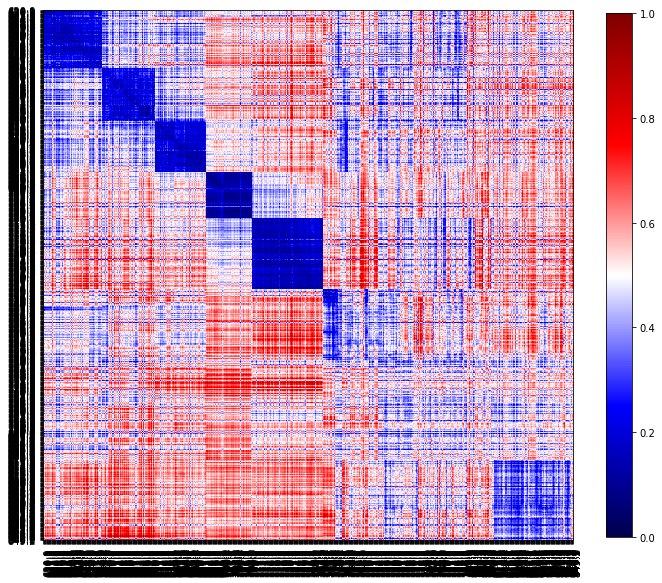

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
norm = plt.Normalize(vmin=0, vmax=1)
im = ax.imshow(cosine, cmap="seismic", norm=norm)


# We want to show all ticks...
ax.set_xticks(np.arange(len(label)))
ax.set_yticks(np.arange(len(label)))
# ... and label them with the respective list entries
ax.set_xticklabels(label)
ax.set_yticklabels(label)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

fig.colorbar(im, ax=ax ,shrink=0.75)

fig.tight_layout()
plt.show()

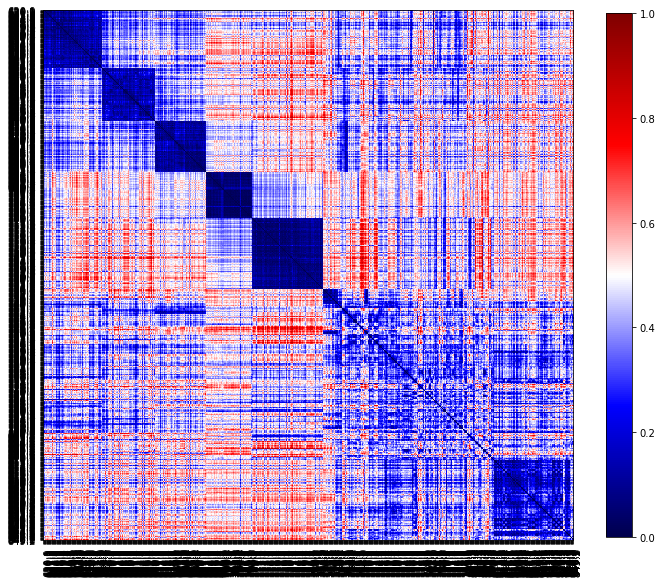

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
norm = plt.Normalize(vmin=0, vmax=1)
im = ax.imshow(predcosine, cmap="seismic", norm=norm)

# We want to show all ticks...
ax.set_xticks(np.arange(len(label)))
ax.set_yticks(np.arange(len(label)))
# ... and label them with the respective list entries
ax.set_xticklabels(label)
ax.set_yticklabels(label)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

fig.colorbar(im, ax=ax ,shrink=0.75)

fig.tight_layout()
plt.show()